# Herbarium 2021 - Half-Earth Challenge - FGVC8 - ResNet

The main goal of this work is to identify plant species of the Americas, Oceania, and the Pacific from herbarium specimens. The dataset that is used in this work - _The Herbarium 2021: Half-Earth Challenge_ - includes more than 2.5M images representing nearly 65.000 species from the Americas and Oceania. These images have been aligned to a standardized plant list ([LCVP v1.0.2](https://www.nature.com/articles/s41597-020-00702-z)).

The model used in this notebook for classifying the images is ResNet ([arXiv:1512.03385](https://arxiv.org/abs/1512.03385)). ResNet makes it possible to train up to hundreds or even thousands of layers and still achieves compelling performance. Taking advantage of its powerful representational ability, the performance of many computer vision applications other than image classification have been bosted. As a classification model, it is considered to be a state-of-the-art method.

## Setup

### Load libraries

In [1]:
# Math and Image
import numpy as np               # Math
import matplotlib.pyplot as plt  # Plot
import cv2                       # OpenCV
import PIL                       # Data Augmentation
import albumentations            # Data Augmentation
from albumentations.pytorch import ToTensorV2
# Operating System
import os
import time
import copy
# Utilities
import pandas as pd  # Handling CSV files
import random
import json
import tqdm          # Testing
import sklearn       # label encoding and metrics
from sklearn import preprocessing
# Torch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
# TensorFlow
import tensorflow as tf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets
# preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved
# outside of the current session will list all files under the input directory

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.7.0
Torchvision Version:  0.8.1


### PC Configuration

In [2]:
# CPU Details - Number & Model
!lscpu | grep "CPU(s):"
!lscpu | grep Hz
# Total Memory
!cat /proc/meminfo | grep MemTotal
# CUDA Check
print("Is CUDA Available?",
      torch.cuda.is_available())
if torch.cuda.is_available() == True: 
    print("Current CUDA device:",
        torch.cuda.get_device_name(0))

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ",DEVICE)

CPU(s):              2
NUMA node0 CPU(s):   0,1
Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz
CPU MHz:             2000.186
MemTotal:       16402016 kB
Is CUDA Available? True
Current CUDA device: Tesla P100-PCIE-16GB
Device:  cuda


### Ramdom seed

The goal is to fix the random seed. For making the environment statically, fixing the random seed is needed. Also, it is essential to reproduce the experimental results.

In [3]:
def seed_fix(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_fix()
print("Seed fixed")

Seed fixed


### Configuration

In [4]:
ROOT_DATA   = "/kaggle/input/herbarium-2021-fgvc8/"
DATA_TRAIN  = ROOT_DATA + "train/"
DATA_TEST   = ROOT_DATA + "test/"
ROOT_OUTPUT = "/kaggle/working/"
META        = "metadata.json"
BATCH_SIZE  = 128    # number of training examples utilized in one iteration
BATCH_EVAL  = 128
SHUFFLE     = True
EPOCHS      = 1
LEARN_RATE  = 4e-4
IMG_HEIGHT  = 224
IMG_WIDTH   = 224
NUM_CLASSES = None   # define below
NUM_WORKERS = 4
PRE_TRAINED = False

PATH_SAVE_MODEL = "/kaggle/working/ResNet50_run-02.pth"

ESTIMATED_MAX_TRAINING_TIME = 480 # hours (8h * 60 = 480min, leaving 1h to the test time)

print(ROOT_DATA)

/kaggle/input/herbarium-2021-fgvc8/


## Create dataset

### Generic information

In [5]:
# Training dataset
with open(os.path.join(DATA_TRAIN,META),"r",encoding="ISO-8859-1") as file:
    meta_train = json.load(file)
    print("Number of images (training dataset): ",
          len(meta_train["images"]),)
    for i in list(meta_train.keys()):
        print("  - sample and number of elements in category {}: ".format(i),
              len(list(meta_train[i])),)
        print("\t[0] ",
              list(meta_train[i])[0], end="\n")

NUM_CLASSES   = len(meta_train["categories"])
NUM_IMG_TRAIN = len(meta_train["annotations"])

# Validation dataset
with open(os.path.join(DATA_TEST,META),"r",encoding="ISO-8859-1") as file:
    meta_test = json.load(file)
    print("\nNumber of images (training dataset): ",
          len(meta_test["images"]),)
    for i in list(meta_test.keys()):
        print("  - sample and number of elements in category {}: ".format(i),
              len(list(meta_test[i])),)
        print("\t[0] ",
              list(meta_test[i])[0], end="\n")

NUM_IMG_TEST  = len(meta_test["images"]) 

# Print variables
print("\n\n"
      "Number of images for training: ",NUM_IMG_TRAIN)
print("Number of images for testing : ",NUM_IMG_TEST)
print("Number of classes            : ",NUM_CLASSES)

Number of images (training dataset):  2257759
  - sample and number of elements in category annotations:  2257759
	[0]  {'category_id': 60492, 'id': 1814367, 'image_id': 1814367, 'institution_id': 0}
  - sample and number of elements in category categories:  64500
	[0]  {'family': 'Orchidaceae', 'order': 'Asparagales', 'name': 'Aa calceata (Rchb.f.) Schltr.', 'id': 0}
  - sample and number of elements in category images:  2257759
	[0]  {'file_name': 'images/604/92/1814367.jpg', 'height': 1000, 'id': 1814367, 'license': 0, 'width': 678}
  - sample and number of elements in category info:  6
	[0]  contributor
  - sample and number of elements in category licenses:  3
	[0]  {'id': 0, 'name': 'Public Domain Dedication', 'url': 'http://creativecommons.org/publicdomain/zero/1.0/'}
  - sample and number of elements in category institutions:  5
	[0]  {'id': 0, 'name': 'New York Botanical Garden'}

Number of images (training dataset):  243020
  - sample and number of elements in category images

### Process training and evaluation metadata

Merge training images and annotations as a dataframe. The database-based joint operation merge is performed on the ids "image_id" (from images dataframe) and "id" (from annotations dataframe).

The problem with the validation data is that the `.json` does not provide the labels to check if the model is classifying correctly or not the validation images.

In [6]:
# Process metadata json for training images into a DataFrame
train_img = pd.DataFrame(meta_train["images"])
train_ann = pd.DataFrame(meta_train["annotations"]).drop(columns="image_id")
train_df  = train_img.merge(train_ann,on="id") # Performs a database-style joint

# Check number of classes
print("Number of classes (expected): ",NUM_CLASSES)
print("Number of classes (computed): ",
      train_df["category_id"].max() - train_df["category_id"].min()+1)
print("\nShape training dataframe    :",train_df.shape)

# Process metadata json for test images into a DataFrame
test_df = pd.DataFrame(meta_test["images"])

Number of classes (expected):  64500
Number of classes (computed):  64500

Shape training dataframe    : (2257759, 7)


In [7]:
# Print the first 5 elements of the tables
train_df.head(n=5)

,file_name,height,id,license,width,category_id,institution_id
0,images/604/92/1814367.jpg,1000,1814367,0,678,60492,0
1,images/108/24/1308257.jpg,1000,1308257,0,666,10824,0
2,images/330/76/1270453.jpg,1000,1270453,0,739,33076,3
3,images/247/99/1123834.jpg,1000,1123834,0,672,24799,0
4,images/170/18/1042410.jpg,1000,1042410,0,675,17018,0


In [8]:
# Print the first 5 elements of the tables
test_df.head(n=5)

,file_name,height,id,license,width
0,images/000/0.jpg,1000,0,0,680
1,images/000/1.jpg,1000,1,0,681
2,images/000/2.jpg,1000,2,0,676
3,images/000/3.jpg,1000,3,0,666
4,images/000/4.jpg,1000,4,0,676


### Checkout samples

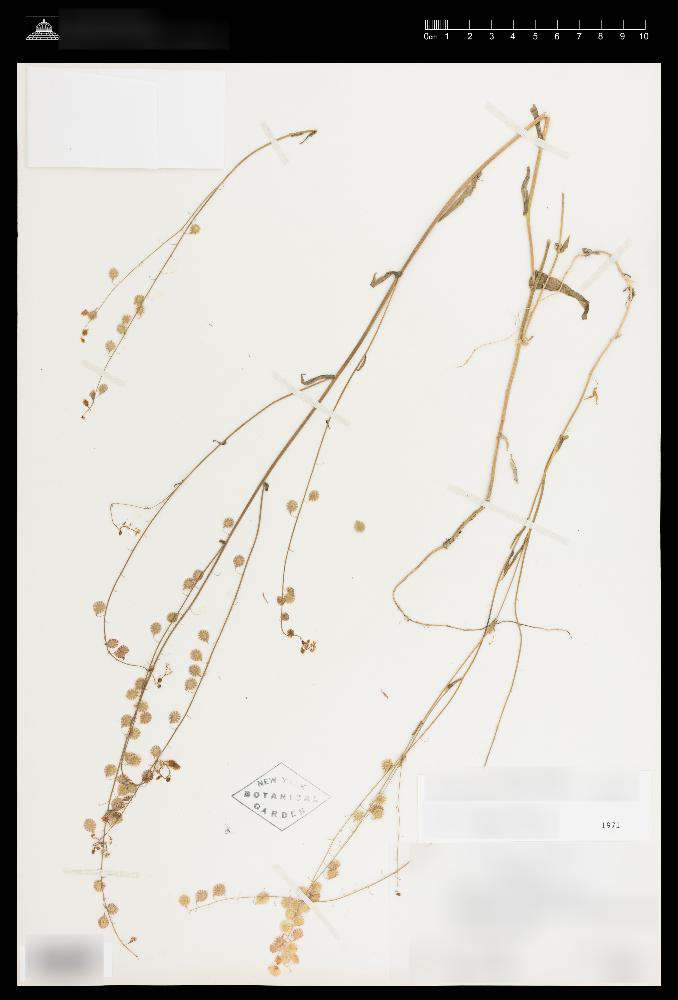

In [9]:
im = PIL.Image.open(DATA_TRAIN + train_df.file_name[0])
im

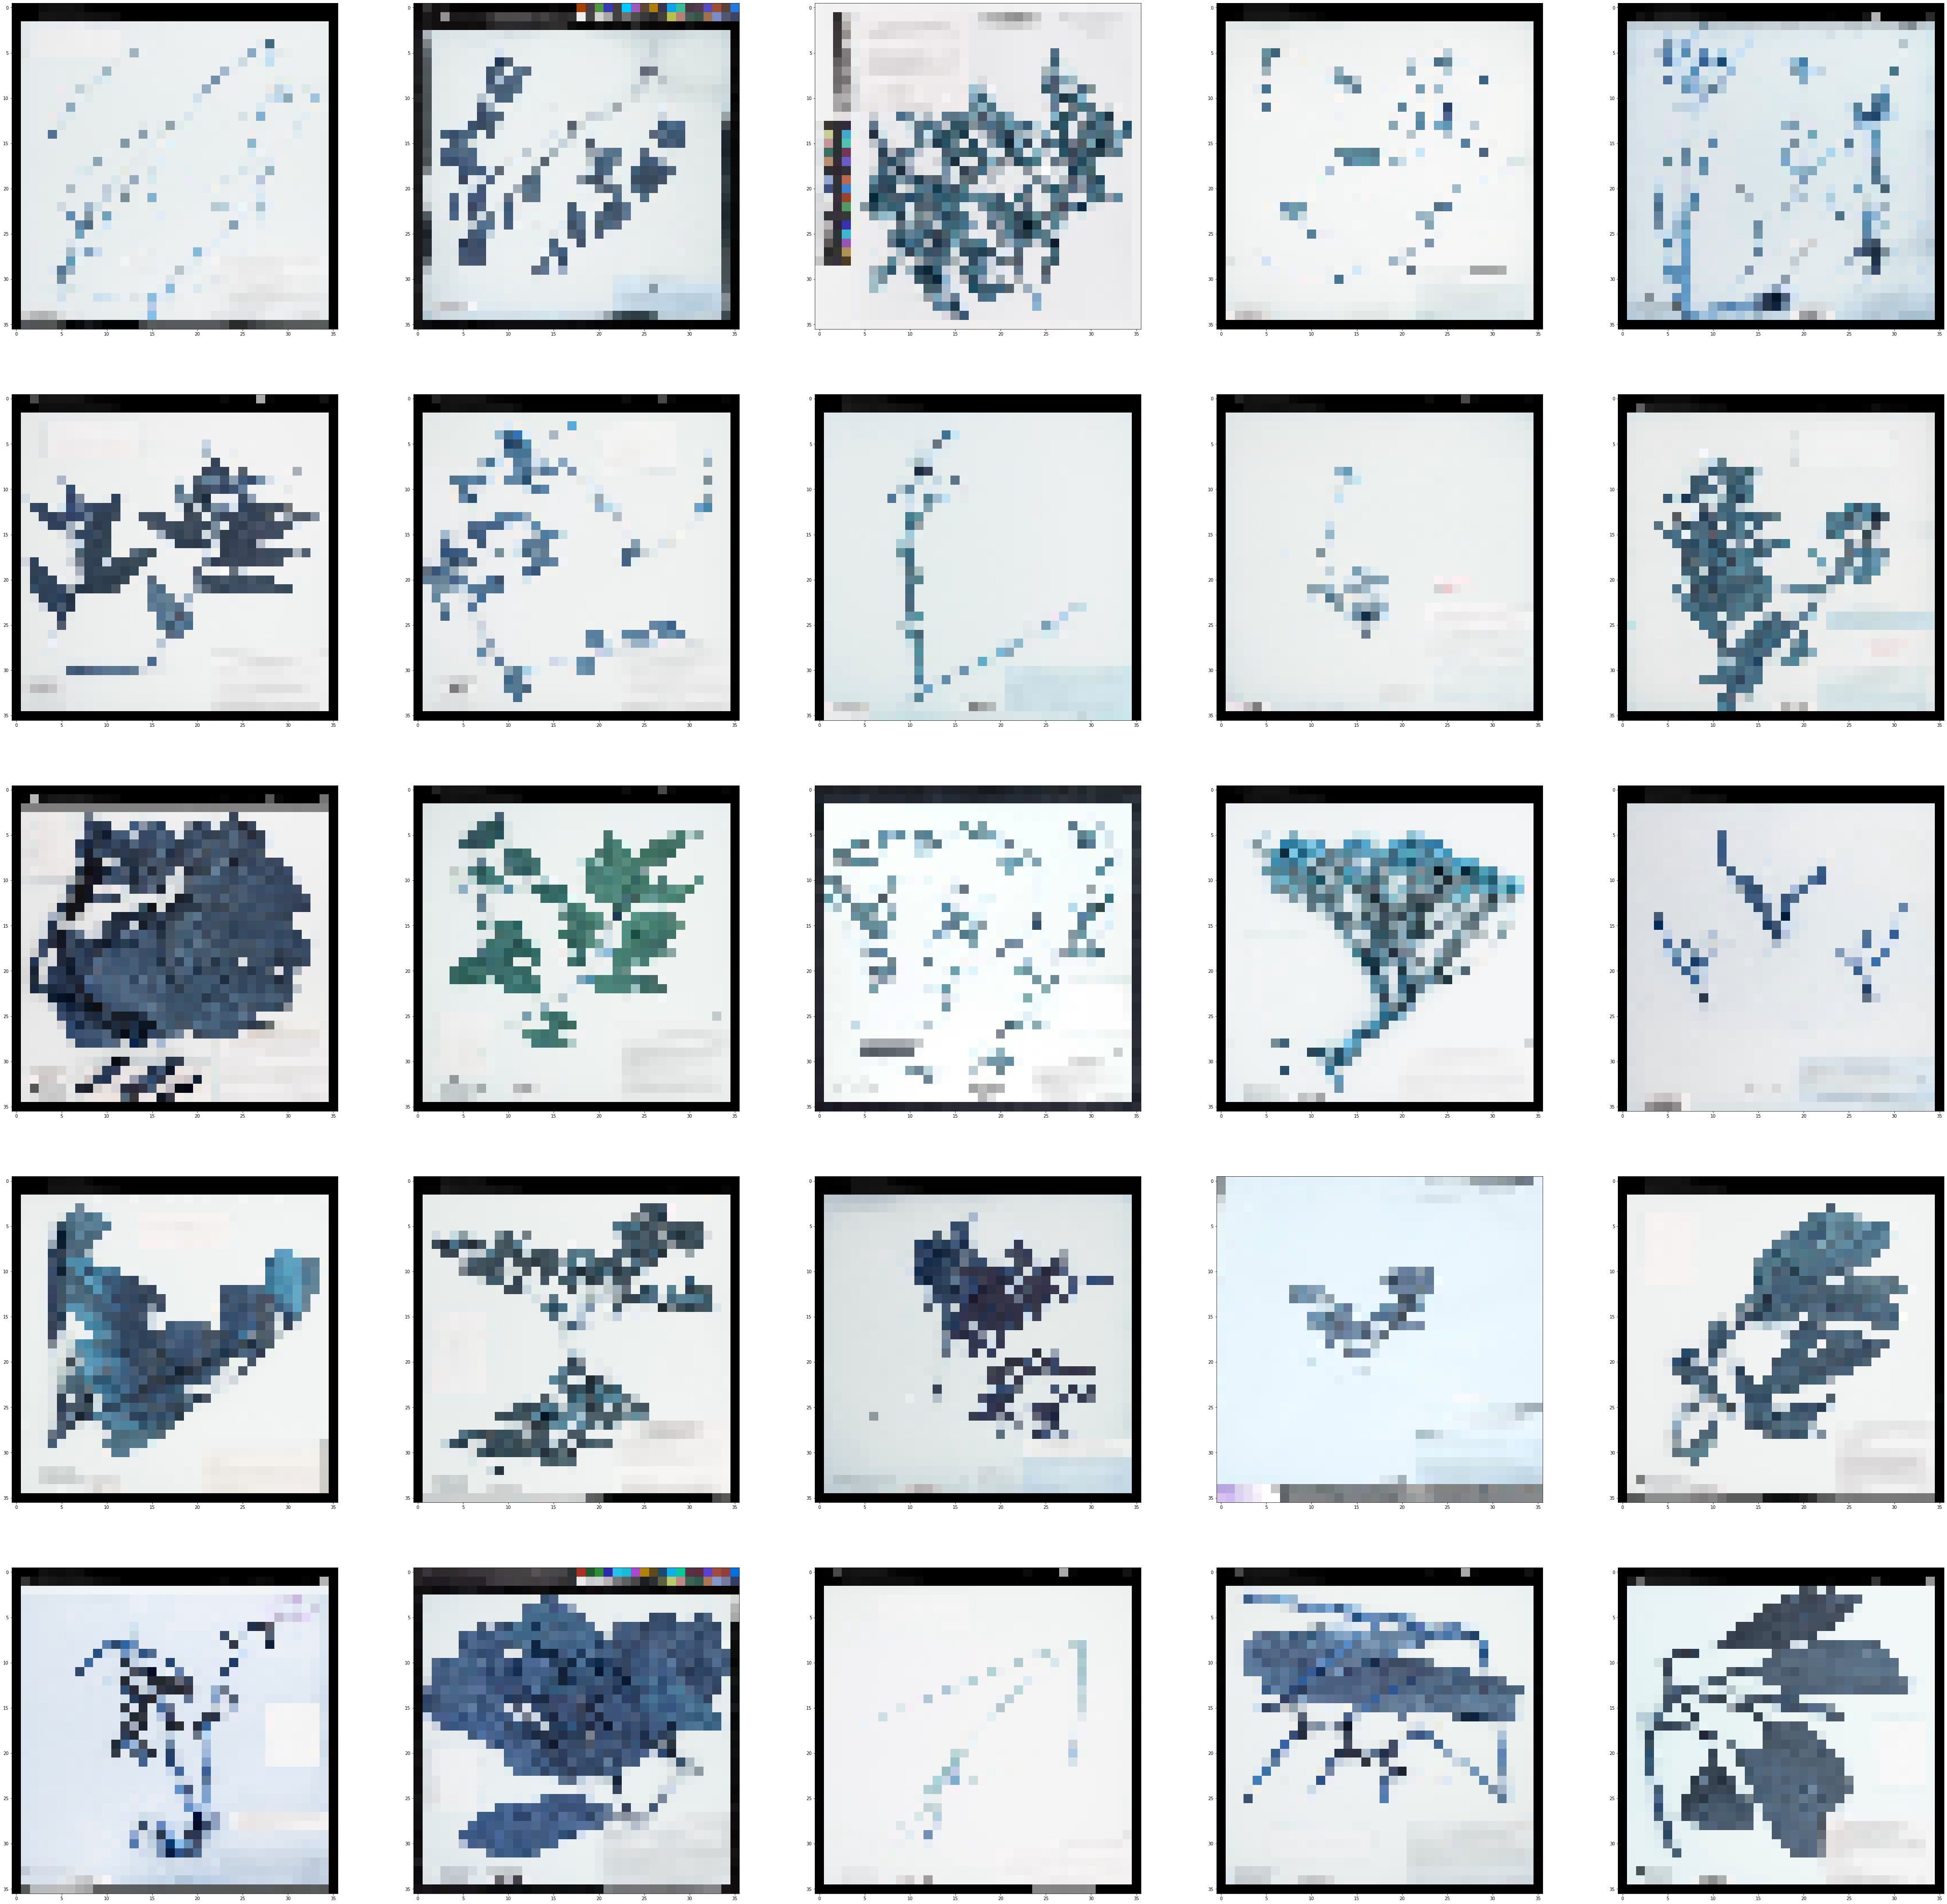

In [10]:
size_of_img = (36,36)
fig=plt.figure(figsize=(80,80))
for i in range(25):
    ax=fig.add_subplot(5,5,i+1)
    img = cv2.imread(DATA_TRAIN + meta_train["images"][i]["file_name"])
    img = cv2.resize(img,size_of_img)
    ax.imshow(img)

plt.show()

## Prepare Submission

In [11]:
sample_submission = pd.read_csv(ROOT_DATA + "sample_submission.csv")
sample_submission.head(n=5)

,Id,Predicted
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


## Label Encoder

In [12]:
# Fit the label encoder instance
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(train_df["category_id"])

# Transform labels to normalized encoding
train_df["category_id_le"] = label_encoder.transform(train_df["category_id"])
class_map = dict(sorted(train_df[["category_id_le","category_id"]].values.tolist()))

print("Labels converted to normalized encoding")

Labels converted to normalized encoding


### Dataloaders

In [13]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, df, labels, transform=None):
        self.df = df
        self.labels = labels
        self.transform = transform
        
    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df["file_name"].values[idx]
        file_path = DATA_TRAIN + file_name
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.labels.values[idx]
        
        if self.transform:
            img = self.transform(image=img)["image"]
        
        return img, label

In [14]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df["file_name"].values[idx]
        file_path = DATA_TEST + file_name
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            img = self.transform(image=img)["image"]
        
        return img

### Image Augmentation

In [15]:
def get_transforms(*, data: str):
    assert data in ("train","test")
    
    if data == "train":
        return albumentations.Compose([
            albumentations.Resize(IMG_HEIGHT,IMG_WIDTH),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == "test":
        return albumentations.Compose([
            albumentations.Resize(IMG_HEIGHT,IMG_WIDTH),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

## Datasets

### Training Dataset

In [16]:
train_df.head(n=5)

,file_name,height,id,license,width,category_id,institution_id,category_id_le
0,images/604/92/1814367.jpg,1000,1814367,0,678,60492,0,60492
1,images/108/24/1308257.jpg,1000,1308257,0,666,10824,0,10824
2,images/330/76/1270453.jpg,1000,1270453,0,739,33076,3,33076
3,images/247/99/1123834.jpg,1000,1123834,0,672,24799,0,24799
4,images/170/18/1042410.jpg,1000,1042410,0,675,17018,0,17018


In [17]:
train_dataset = TrainDataset(
    train_df,train_df["category_id_le"],
    transform=get_transforms(data="train"))
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,shuffle=SHUFFLE,num_workers=NUM_WORKERS)
print("Train data loader created")

Train data loader created


### Test Dataset

In [18]:
test_df.head(n=5)

,file_name,height,id,license,width
0,images/000/0.jpg,1000,0,0,680
1,images/000/1.jpg,1000,1,0,681
2,images/000/2.jpg,1000,2,0,676
3,images/000/3.jpg,1000,3,0,666
4,images/000/4.jpg,1000,4,0,676


In [19]:
test_dataset = TestDataset(
    test_df,
    transform=get_transforms(data="test"))
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_EVAL,shuffle=False,num_workers=NUM_WORKERS)
print("Test data loader created")

Test data loader created


## Model

In [20]:
def train_model(model,dataloader,criterion,optimizer,num_epochs=1):
    since = time.time()
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        model.train()
        
        running_loss = 0.0
        running_corrects = 0
        
        #for inputs, labels in tqdm.tqdm(enumerate(dataloader)):
        i = 0
        len_dataset = len(dataloader.dataset)
        for inputs, labels in dataloader:
            since_tmp = time.time()
            
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = criterion(outputs,labels)
                
                _,preds = torch.max(outputs,1)
                
                loss.backward()
                optimizer.step()
              
            loss_tmp = loss.item()
            pred_tmp = torch.sum(preds == labels.data)
            
            running_loss += loss_tmp * inputs.size(0)
            running_corrects += pred_tmp
            
            time_elapsed_tmp = time.time() - since_tmp
            
            print('  loss: {:.04f} corr: {:d} ({:d}/{:d}) completed in {:.0f}m {:.03f}s'.format(
                loss_tmp, pred_tmp,(i+1)*BATCH_SIZE,len_dataset,
                time_elapsed_tmp // 60, time_elapsed_tmp % 60))
            
            if ((time.time() - since) // 60 > ESTIMATED_MAX_TRAINING_TIME):
                break;
            
            i += 1
            
        epoch_loss = running_loss / len_dataset
        epoch_acc = running_corrects.double() / len_dataset
        
        torch.save(model.state_dict(),PATH_SAVE_MODEL)
        print(PATH_SAVE_MODEL)
        print('Loss: {:.04f} Acc: {:.04f}'.format(epoch_loss, epoch_acc))
        
        print()
            
        if ((time.time() - since) // 60 > ESTIMATED_MAX_TRAINING_TIME):
            break;
        
    time_elapsed = time.time() - since
    print('Loss: {:.04f} Acc: {:.04f}'.format(epoch_loss, epoch_acc))
    print('Training complete in {:.0f}m {:.03f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    #model.load_state_dict(best_model_wts)
    return model

### Construct model

In [21]:
model = torchvision.models.resnet50(pretrained=PRE_TRAINED)
model.avgpool = torch.nn.AdaptiveAvgPool2d(1)
model.fc = torch.nn.Linear(model.fc.in_features,NUM_CLASSES)

### Use existent trained model

In [22]:
model.load_state_dict(torch.load("../input/herbarium-2021-rbs/ResNet50_run-01.pth"))

<All keys matched successfully>

### Train

In [23]:
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARN_RATE, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', factor=0.75, patience=5, verbose=True, eps=1e-6)

criterion = torch.nn.CrossEntropyLoss()

In [24]:
model = train_model(model,train_loader,criterion,optimizer,EPOCHS)

Epoch 0/0
----------
  loss: 3.9132 corr: 36 (128/2257759) completed in 0m 2.885s
  loss: 3.2301 corr: 52 (256/2257759) completed in 0m 0.806s
  loss: 3.1068 corr: 56 (384/2257759) completed in 0m 0.826s
  loss: 3.3327 corr: 55 (512/2257759) completed in 0m 0.782s
  loss: 2.9696 corr: 58 (640/2257759) completed in 0m 0.855s
  loss: 2.7767 corr: 58 (768/2257759) completed in 0m 0.833s
  loss: 3.4030 corr: 49 (896/2257759) completed in 0m 0.840s
  loss: 3.0491 corr: 59 (1024/2257759) completed in 0m 0.904s
  loss: 2.5525 corr: 59 (1152/2257759) completed in 0m 0.815s
  loss: 3.3045 corr: 60 (1280/2257759) completed in 0m 0.837s
  loss: 3.0992 corr: 58 (1408/2257759) completed in 0m 0.809s
  loss: 3.4018 corr: 47 (1536/2257759) completed in 0m 0.843s
  loss: 3.7365 corr: 60 (1664/2257759) completed in 0m 0.827s
  loss: 3.6802 corr: 50 (1792/2257759) completed in 0m 0.820s
  loss: 3.7904 corr: 53 (1920/2257759) completed in 0m 0.835s
  loss: 3.1882 corr: 58 (2048/2257759) completed in 0m 0

## Inference

In [25]:
model.eval()
model.to(DEVICE)

predictions = np.zeros((len(test_dataset)))

for i,images in tqdm.tqdm(enumerate(test_loader)):
    images = images.to(DEVICE)
    with torch.no_grad():
        y_predictions = model(images)

    predictions[i*BATCH_EVAL:(i+1)*BATCH_EVAL] = y_predictions.to(DEVICE).cpu().numpy().argmax(1)

1899it [44:37,  1.41s/it]


## Submit

In [26]:
test_df["preds"] = predictions.astype(int)
submission = sample_submission.merge(
    test_df.rename(columns = {"id":"Id"})[["Id","preds"]],on="Id"
).drop(columns="Predicted")
submission["Predicted"] = submission["preds"].map(class_map)
submission = submission.drop(columns="preds")
submission.to_csv("submission.csv",index=False)
submission.head()

,Id,Predicted
0,0,45270
1,1,14236
2,2,35602
3,3,38896
4,4,4753
